In [1]:
import scipy.integrate as spint
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import cbsyst as cb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
class threebox_biotic_carbon():
    """ three box model for ocean"""
    
    def __init__(self, area_ocean=3.4e14, atmmol = 1.8e20, rho = 1025):
        """ constructor
        PARAMETERS:
        area_ocean: float
            area of the ocean in m2
        atmmol: float
            mol gas in atmosphere in mol/atm
        density: float
            water density in kg/m3
        """
        self.area_ocean = area_ocean
        self.atmmol = atmmol
        self.rho = rho
        return None
    
    def integrate_tracer(self, name='Carbon', DIC_ini_deep=2300, 
                         DIC_ini_lo=2000, DIC_ini_hi=2150,  
                         dz_deep=4000, dz_lo=100, dz_hi=100, hi_area=0.15, 
                         T=45, fhd=60, 
                         NPP_lo=300, NPP_hi=600, ez_ratio_lo=0.12, ez_ratio_hi=0.2,
                         ALK=2350, 
                         tempC_deep=2, tempC_lo=21.5, tempC_hi=2, 
                         salt=35, 
                         atmC_ini=280, kw=15,
                         run_duration=500):
        """ time integration of the three box equation, biotic, with carbon
        PARAMETERS:
        DIC_ini_deep, _lo, _hi: float
            initial concentration of DIC mmol/m3
        atmC_ini: float
            initial atmosphere carbon (uatm), converted to mol
            
        "" Geometry ""    
        dz_deep, _lo,_hi: float
            box depth in m
        hi_area: float
            High latitude as 15% of ocean area (HBEI papers), 3% suggested by S&G06 (pg 438)
            
         "" Ocean circulation ""    
        T: float
            overturning in Sv (1 Sv = 1e6 m3/s; converted to m3/yr)
            modern overturning, 25-40 Sv (1 Sv = 1e6 m3/s)
        fhd: float
            deep / high mixing in Sv (converted  to m3/yr)
            S&G06 give modern ~60Sv, Glacial ~19Sv (pg 441) 
            
        "" Ocean biology and carbon export ""    
        NPP_lo: float
            low latitude productivity (mgC/m2/d) (converted to mmolC/yr)
            Modern = 200-400 mgC/m2/d (Westberry et al 2008)
        NPP_hi: float
            high latitude productivity (mgC/m2/d) (converted to mmolC/yr)
            Modern = 500-800 mgC/m2/d (Westberry et al 2008)
        ez_ratio: float
            ez_ratio = Carbon Export / NPP (also called e-ratio,ef-ratio)
            Modern global mean ~ 0.15 (Siegel et al. 2016), but at bloom peak up to ~0.5
            
         "" Ocean carbon system ""    
         ALK: float
             alkalinity, global constant (mmol/m3)
         TempC_deep, _lo, _hi: float
             temperature (C) for each box
         Salt: float
             salinity (psu) global constant
         unitconvert: float
             to go from model of mol/m3 to umol/kg in cbsyst

         "" Air-sea CO2 flux""  
         kw: float
             piston velocity (cm/hr), typical 15 cm/hr (will be converted to m/yr)
         pco2_atm: float
             pCO2_atm = (C(:,4)./atmmol).*1e6; 
             
         run_duration: float
            integration time in years                     
        """
        self.name = name
        
        " bug fix on 2 Dec 2019, to include hi_area in volume calculation; also have to reduce max_step"
        self.hi_area = hi_area
        self.volume = np.array([self.area_ocean*dz_deep, self.area_ocean*(1-self.hi_area)*dz_lo, self.area_ocean*self.hi_area*dz_hi])
        
        "unit conversions"
        self.unitconvert=1000/self.rho
        self.T = T*1e6*(60*60*24*365)
        self.fhd = fhd*1e6*(60*60*24*365)
        
        self.NPP_lo = NPP_lo*((1-self.hi_area)*self.area_ocean*(1/12)*(365))
        self.NPP_hi = NPP_hi*(self.hi_area*self.area_ocean*(1/12)*(365))
        
        self.ez_ratio_lo = ez_ratio_lo
        self.ez_ratio_hi = ez_ratio_hi
        
        self.kw = kw*(1/100)*(24*365)
        self.atmC_ini= (atmC_ini/self.atmmol)*1e6
        
        " set up vectors "
        self.tempC = np.array([tempC_deep, tempC_lo, tempC_hi])
        self.salt =  np.array([salt, salt, salt])
        self.ALK = np.array([ALK, ALK, ALK])
        
        " vector to integrate in mmol/m3 for ocean, mol for atm"
        self.DIC_ini = np.array([DIC_ini_deep,DIC_ini_lo,DIC_ini_hi,atmC_ini*1e-6*self.atmmol])
 
        self.time_ini = 0
        self.time_end = run_duration
        # integration the box equation with RK45
        solver = spint.solve_ivp(self.ocean_threebox_biotic_carbon_equations, (self.time_ini, self.time_end,), 
                                 self.DIC_ini, method='RK45', vectorized='True', max_step=1)
        self.time = solver['t']
        self.tracer_conc = solver['y'].squeeze()
        
        # Find pCO2 for output
        pco2_deep=cb.Csys(DIC=self.unitconvert*self.tracer_conc[0],T_in=self.tempC[0], S_in=self.salt[0], TA=self.unitconvert*self.ALK[0]).pCO2
        pco2_lo=cb.Csys(DIC=self.unitconvert*self.tracer_conc[1],T_in=self.tempC[1], S_in=self.salt[1], TA=self.unitconvert*self.ALK[1]).pCO2
        pco2_hi=cb.Csys(DIC=self.unitconvert*self.tracer_conc[2],T_in=self.tempC[2], S_in=self.salt[2], TA=self.unitconvert*self.ALK[2]).pCO2
        pco2_atm = self.tracer_conc[3]*1e6/1.8e20
        self.tracer_pco2 = np.array([pco2_deep, pco2_lo, pco2_hi, pco2_atm])
        
        # plot the results
        self.plot_threebox_biotic_carbon()
        return self.time, self.tracer_conc, self.tracer_pco2
        
    def plot_threebox_biotic_carbon(self):
        ## plot as DIC 
        ## FOR BIGGER PLOTS: plt.figure(figsize=[10,8])
        plt.figure(figsize=[8,6])
        plt.plot(self.time, self.tracer_conc[0], color='green')
        plt.plot(self.time, self.tracer_conc[1], color='blue')
        plt.plot(self.time, self.tracer_conc[2], color='black')
        plt.xlabel('years',fontsize=16)
        plt.ylabel('DIC: Low (b), High (blk), Deep (g) [mmol/m3]', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title('DIC in three box model + atmosphere (Fig 10.4.3, SG06)', fontsize=16)
            
        ## plot as pCO2 
        plt.figure(figsize=[8,6])
        plt.plot(self.time, self.tracer_pco2[3], color='red')
        plt.plot(self.time, self.tracer_pco2[1], color='blue')
        plt.plot(self.time, self.tracer_pco2[2], color='black')
        #plt.plot(self.time, self.tracer_conc[0], color='green')
        plt.xlabel('years',fontsize=16)
        plt.ylabel('pCO2: Atm (r), Low (b), High (blk) [uatm]', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title('pCO2 for in three box model + atmosphere (Fig 10.4.3, SG06)', fontsize=16)
        
        return None
        
    def ocean_threebox_biotic_carbon_equations(self, time, conc):
        " Ocean carbon chemistry, to find pCO2 (in uatm, convert to atm) and k0 (mol/kg/atm))"
        Csw_lo= cb.Csys(DIC=self.unitconvert*conc[1],T_in=self.tempC[1], S_in=self.salt[1], TA=self.unitconvert*self.ALK[1])
        Csw_pco2_lo = 1e-6*Csw_lo.pCO2
        Csw_k0_lo = Csw_lo.Ks.K0

        Csw_hi= cb.Csys(DIC=self.unitconvert*conc[2],T_in=self.tempC[2], S_in=self.salt[2], TA=self.unitconvert*self.ALK[2])
        Csw_pco2_hi = 1e-6*Csw_hi.pCO2
        Csw_k0_hi = Csw_hi.Ks.K0
       
        "Convert atmospheric pCO2 back to atm"
        pCO2atm = conc[3]/self.atmmol
        
        "Air-sea flux = (kw*ko*rho)*(pCO2atm - pCO2ocean)*area [(mmol/mol)*(mol/m2/yr)*(m2) = mmol/yr]; positive to atm, negative to ocean"
        airsea_flux_lo = 1e3*(self.kw*Csw_k0_lo*self.rho*(Csw_pco2_lo - pCO2atm)*self.area_ocean*(1-self.hi_area) )
        airsea_flux_hi = 1e3*(self.kw*Csw_k0_hi*self.rho*(Csw_pco2_hi - pCO2atm)*self.area_ocean*(self.hi_area) )
        
        " Ocean integrated in mmol/m3/yr, atmosphere integrated in mol/yr"
        dconc_deepdt = (self.T*(conc[2] - conc[0]) + self.fhd * (conc[2] - conc[0])
                        + self.ez_ratio_lo*self.NPP_lo + self.ez_ratio_hi*self.NPP_hi ) / self.volume[0]
        dconc_lodt =(self.T * (conc[0] - conc[1])
                        - self.ez_ratio_lo*self.NPP_lo  -  airsea_flux_lo )/ self.volume[1]
        dconc_hidt = (self.T * (conc[1] - conc[2]) + self.fhd * (conc[0] - conc[2])
                       - self.ez_ratio_hi*self.NPP_hi -  airsea_flux_hi ) / self.volume[2]
        dconc_atmdt = 1e-3*(airsea_flux_lo + airsea_flux_hi)
        
        return np.array([dconc_deepdt, dconc_lodt, dconc_hidt, dconc_atmdt]) 

In [4]:
boxmodel = threebox_biotic_carbon()

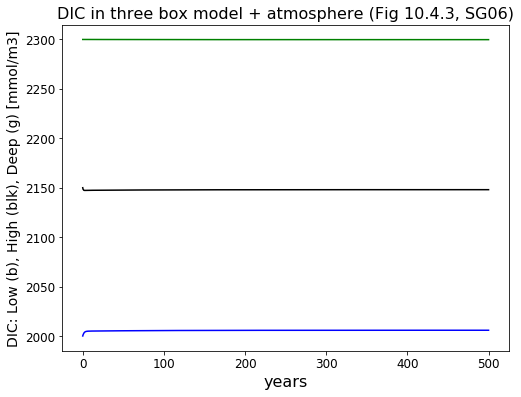

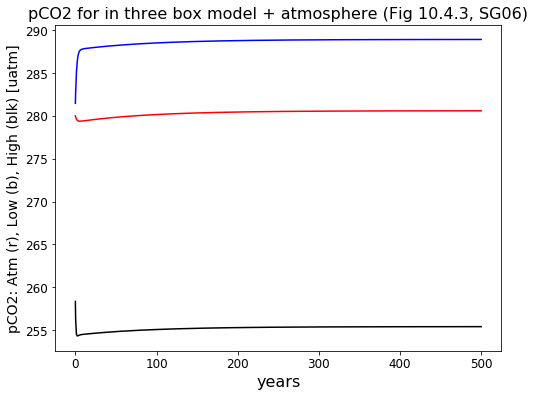

In [5]:
t, c_conc, pco2 = boxmodel.integrate_tracer()